In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image 
from os import listdir
from matplotlib import pyplot
import os
from numpy import asarray 
from os.path import isdir, join , exists
from numpy import load , expand_dims

In [6]:
import zipfile

with zipfile.ZipFile(r"C:\Users\gupta\Downloads\model-20241103T130609Z-001.zip", 'r') as zip_ref:
    zip_ref.extractall(r"C:\Users\gupta\Downloads\model-20241103T130609Z-001")


In [ ]:
# first we will make image segmentation then we will make face classification
# for image segmentation we will load MTCNN librery 
# it will bound the face by box in each image

In [ ]:
from mtcnn.mtcnn import MTCNN
def extract_face(filename , required_shape = (160 ,160)):
    image = Image.open(filename)
    image = image.convert('RGB')#if some image are gray scale
    pixels = np.asarray(image)
    mtcnn = MTCNN()
    result = mtcnn.detect_faces(pixels)#detect the face
    if len(result) == 0:
        print(f"No face detected in image: {filename}")
        return None  # Return None if no face is detected
    x1 , y1 , width , height = result[0]['box']
    x1  , y1 = abs(x1) ,abs(y1)# x1  , y1 can be negative, because of some bugs , to solve we will use absolute value
    x2 , y2 = x1 + width , y1 +height
    face = pixels[y1:y2 ,x1:x2]#got image
    image = Image.fromarray(face)#resizing the image
    image = image.resize(required_shape)
    face_array = np.asarray(image)
    return face_array


1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


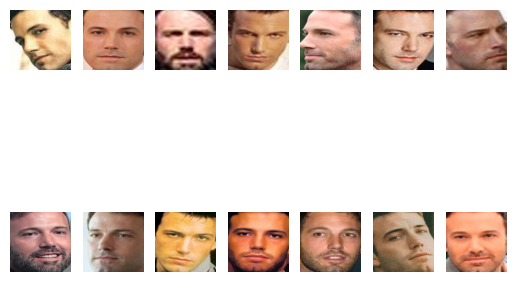

In [29]:
#now this pixels will be used in next section i.e., in face recognition section to predict the identity of the face
#showing image
folder = r"C:\Users\gupta\Downloads\archive\data\train\ben_afflek"
i =1 
for i, filename in enumerate(listdir(folder), 1):
    path = os.path.join(folder, filename)
    face = extract_face(path)
    print(i , face.shape)
    pyplot.subplot(2 ,7,i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i+=1
pyplot.show()


In [ ]:
def load_faces(directory):
    faces = []
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} not found.")
        return faces st

    for i, filename in enumerate(os.listdir(directory), 1):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):  # Only process if it's a file
         
            face = extract_face(file_path)
            if face is not None:
                faces.append(face)
    return faces

In [ ]:
# x -> faces , y->their class
def load_dataset(path):
    x, y = [], []
    for subdir in os.listdir(path):
        dir_path = os.path.join(path, subdir)
        if os.path.isdir(dir_path): 
            faces = load_faces(dir_path)
            labels = [subdir] * len(faces)  # Label each face with the class name
            x.extend(faces)
            y.extend(labels)
            print(f'>loaded {len(faces)} examples for class: {subdir}')
    return asarray(x), asarray(y)

In [50]:
from numpy import savez_compressed 
x_train , y_train = load_dataset(r"C:\Users\gupta\Downloads\archive\train")
print(x_train.shape , y_train.shape) 

x_test , y_test = load_dataset(r"C:\Users\gupta\Downloads\archive\val")
print(x_test.shape , y_test.shape)
savez_compressed('face-detection-dataset.npz' , x_train , y_train , x_test , y_test)

>loaded 14 examples for class: ben_afflek
No face detected in image: C:\Users\gupta\Downloads\archive\train\elton_john\httpsuploadwikimediaorgwikipediacommonsthumbEltonJohninsjpgpxEltonJohninsjpg.jpg
>loaded 16 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(92, 160, 160, 3) (92,)
>loaded 5 examples for class: ben_afflek
No face detected in image: C:\Users\gupta\Downloads\archive\val\elton_john\httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTEODAOTcxNjcMjczMjkzjpg.jpg
>loaded 4 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling
(24, 160, 160, 3) (24,)


In [51]:
savez_compressed('face-detection-dataset.npz' , x_train , y_train , x_test , y_test)

In [ ]:
data = load(r'C:\Users\gupta\OneDrive\Documents\computer vision\face classification project\face-detection-dataset.npz')
x_train , y_train , x_test , y_test = data['arr_0'] ,data['arr_1'] ,data['arr_2'] ,data['arr_3']

In [53]:
# face embedding is a vector contains the features of the face 
# and this vector is matched with other vector , person can be same if vector are nearly same
# the facenet model will predict the embeded vector

### generating embedding

In [ ]:
from keras_facenet import FaceNet
model = FaceNet()

In [ ]:
def get_embedding(x_train):
    embeddings =[]
    for img in x_train:
        face_embedding = model.extract(img, threshold=0.95)
        if len(face_embedding) > 0:
            embeddings.append(face_embedding[0]['embedding'])
        else:
            # Append a placeholder if no embedding is generated
            placeholder = np.zeros(512)  # Adjust `model.embedding_dim` to the embedding size
            embeddings.append(placeholder)
    return asarray(embeddings)

In [67]:
print(x_train.shape)
print(x_test.shape)
new_xtrain = get_embedding(x_train)
new_xtest = get_embedding(x_test)
print(new_xtrain.shape)
print(new_xtest.shape)


(92, 160, 160, 3)
(24, 160, 160, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1

In [68]:
from numpy import savez_compressed 
savez_compressed('face-detection-embedded-dataset.npz' , new_xtrain , y_train , new_xtest , y_test)

In [69]:
embedded_data =  load(r'C:\Users\gupta\OneDrive\Documents\computer vision\face classification project\face-detection-embedded-dataset.npz')
x_train , y_train , x_test, y_test = embedded_data['arr_0'] , embedded_data['arr_1'], embedded_data['arr_2'], embedded_data['arr_3']
print(x_train.shape ,x_test.shape)

(92, 512) (24, 512)


In [73]:
# it is a good practice to normalise the embedded vector havong length 1 unit as we going to compare the vector
# and label encoded the y set
from sklearn.preprocessing import Normalizer , LabelEncoder
in_encoder = Normalizer(norm = 'l2')
x_train = in_encoder.transform(x_train)
x_test = in_encoder.transform(x_test)

out_encoder = LabelEncoder()
y_train  = out_encoder.fit_transform(y_train)
y_test  = out_encoder.transform(y_test)


In [75]:
# loading SVM model(for comparing)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
model2  = SVC(kernel = 'linear')

In [76]:
model2.fit(x_train, y_train)
y_pred = model2.predict(x_test)
accuracy_score(y_pred, y_test) 

1.0

In [77]:
predictd_class = out_encoder.inverse_transform(y_pred)
print(predictd_class)

['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'mindy_kaling'
 'mindy_kaling' 'mindy_kaling' 'mindy_kaling' 'mindy_kaling']


let's try for random image

In [ ]:
def test(filename):
    pixel_faces = extract_face(filename)
    if pixel_faces.ndim == 3:  # If it's a single image
        pixel_faces = np.expand_dims(pixel_faces, axis=0)
    embedding = get_embedding(pixel_faces)
    embedding = embedding.reshape(1, -1)
    in_encoder = Normalizer(norm = 'l2')
    embedding = in_encoder.transform(embedding)
    y_pred = model2.predict(embedding)  
    predictd_class = out_encoder.inverse_transform(y_pred)
    print(predictd_class)

In [85]:
test(r"C:\Users\gupta\Downloads\images.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
['madonna']
